<a href="https://colab.research.google.com/github/jagadeeshkadal/DataAnalyticsInternship-codetechit/blob/master/Task1_1%5BData_Analysis_using_pyspark%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To perform data analysis using PySpark on a large dataset, we'll utilize the Open Food Facts database, a comprehensive dataset containing nutritional information about food products worldwide. This dataset is publicly accessible and suitable for large-scale data processing tasks. ​
Medium

Below is a step-by-step guide, including PySpark code snippets and explanations for each step.

Here's how to run PySpark in Google Colab:
Step 1: Install PySpark
Paste this in the first cell

In [1]:
!pip install -q pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Colab Spark Setup") \
    .getOrCreate()


Check the environment is working or not

In [3]:
# Create a simple dataframe
data = [("Alice", 25), ("Bob", 30), ("Charlie", 35)]
columns = ["Name", "Age"]

df = spark.createDataFrame(data, columns)
df.show()


+-------+---+
|   Name|Age|
+-------+---+
|  Alice| 25|
|    Bob| 30|
|Charlie| 35|
+-------+---+



📊 Dataset: Netflix Movies and TV Shows
Source: Kaggle
Name: netflix_titles.csv
Description: Contains info on movies/shows, release years, ratings, countries, etc.

Task Plan:
Load the dataset into PySpark

Explore structure and schema

Clean missing data

Analyze top content-producing countries

Find most common genres (listed under "listed_in")

Filter data (e.g., shows released after 2015)

Do basic aggregations

Step 1: Upload Dataset

In [5]:
!wget https://raw.githubusercontent.com/prasertcbs/basic-dataset/master/netflix_titles.csv


--2025-04-08 12:05:58--  https://raw.githubusercontent.com/prasertcbs/basic-dataset/master/netflix_titles.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2410660 (2.3M) [text/plain]
Saving to: ‘netflix_titles.csv’

netflix_titles.csv  100%[===================>]   2.30M  --.-KB/s    in 0.07s   

2025-04-08 12:05:58 (32.7 MB/s) - ‘netflix_titles.csv’ saved [2410660/2410660]



Step 2: Load into PySpark

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Netflix Data Analysis").getOrCreate()

# Load the CSV
df = spark.read.csv("netflix_titles.csv", header=True, inferSchema=True)

# Show the schema
df.printSchema()

# Preview the first few rows
df.show(5)


root
 |-- show_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = true)
 |-- description: string (nullable = true)

+--------+-------+--------------------+--------------------+--------------------+--------------------+-----------------+------------+--------+--------+--------------------+--------------------+
| show_id|   type|               title|            director|                cast|             country|       date_added|release_year|  rating|duration|           listed_in|         description|
+--------+-------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------

 Step 2: Basic Exploration of dataset

In [7]:
# Count total records
print("Total records:", df.count())

# Show distinct types (Movie or TV Show)
df.select("type").distinct().show()

# Count of each type
df.groupBy("type").count().show()

# Null value summary
from pyspark.sql.functions import col, isnan, when, count

df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show()


Total records: 6236
+-------------+
|         type|
+-------------+
|      TV Show|
|        Movie|
|William Wyler|
|         NULL|
+-------------+

+-------------+-----+
|         type|count|
+-------------+-----+
|         NULL|    1|
|      TV Show| 1969|
|        Movie| 4265|
|William Wyler|    1|
+-------------+-----+

+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|show_id|type|title|director|cast|country|date_added|release_year|rating|duration|listed_in|description|
+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|      0|   1|    2|    1971| 571|    478|        13|           2|    12|       2|        3|          3|
+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+



Step 3: Handle Nulls (minimal cleaning, only where needed)

In [9]:
# Drop rows where 'title' or 'type' is null (essential fields)
df_cleaned = df.dropna(subset=["title", "type"])

# Fill missing 'country' with 'Unknown'
df_cleaned = df_cleaned.fillna({'country': 'Unknown'})


Step 4: Example Analysis — Top 10 countries by content

In [10]:
df_cleaned.groupBy("country") \
    .count() \
    .orderBy("count", ascending=False) \
    .show(10)


+--------------+-----+
|       country|count|
+--------------+-----+
| United States| 2024|
|         India|  777|
|       Unknown|  477|
|United Kingdom|  348|
|         Japan|  176|
|        Canada|  141|
|   South Korea|  136|
|         Spain|  117|
|        France|   90|
|        Mexico|   83|
+--------------+-----+
only showing top 10 rows



Step 5: Filter — Only Movies in India

In [11]:
df_cleaned.filter((col("type") == "Movie") & (col("country") == "India")) \
    .select("title", "release_year", "rating") \
    .orderBy("release_year", ascending=False) \
    .show(10)


+--------------------+------------+------+
|               title|release_year|rating|
+--------------------+------------+------+
|       Ghost Stories|        2020| TV-MA|
|            Noblemen|        2019| TV-MA|
|        House Arrest|        2019| TV-14|
|      Mehandi Circus|        2019| TV-14|
|            Watchman|        2019| TV-14|
|            Upstarts|        2019| TV-14|
|Oh! Baby (Malayalam)|        2019| TV-14|
|Oththa Seruppu Si...|        2019| TV-MA|
|        Manmadhudu 2|        2019| TV-MA|
|     The Zoya Factor|        2019| TV-14|
+--------------------+------------+------+
only showing top 10 rows



Let's power up PySpark setup in Colab with visualizations using Matplotlib and Pandas after collecting results from Spark.

We'll use this flow:

Use Spark for heavy lifting

Convert results to Pandas

Plot using Matplotlib

Step 1: Install required packages (if not already)
{matplotlib seaborn}

In [12]:
!pip install matplotlib seaborn

Step 2: Visualization — Top 10 countries with most Netflix content

<ipython-input-13-2a41bd444514>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pandas_country_df, x='count', y='country', palette="rocket")


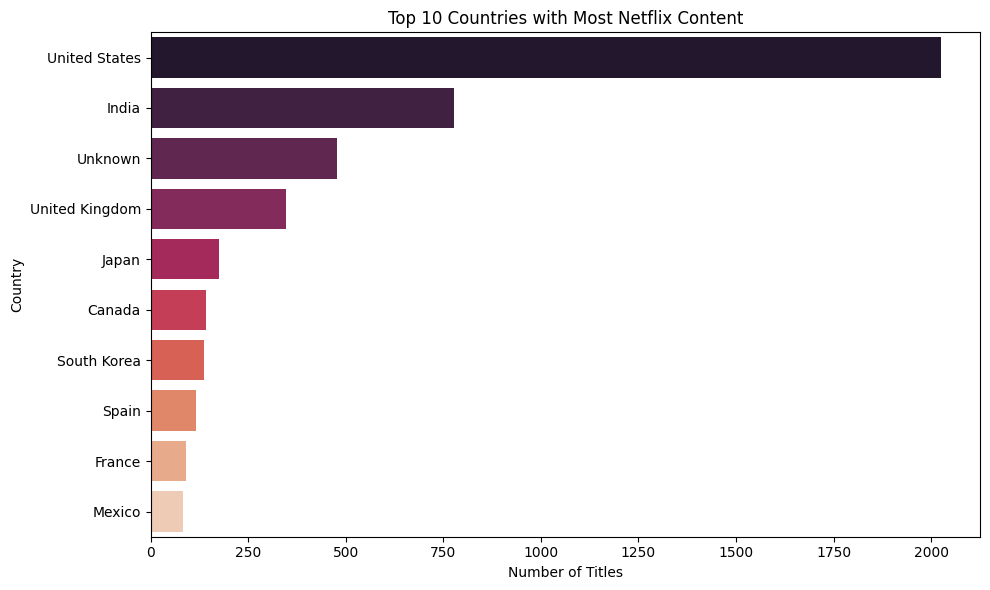

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate in Spark
country_df = df_cleaned.groupBy("country").count().orderBy("count", ascending=False).limit(10)

# Convert to Pandas for plotting
pandas_country_df = country_df.toPandas()

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=pandas_country_df, x='count', y='country', palette="rocket")
plt.title("Top 10 Countries with Most Netflix Content")
plt.xlabel("Number of Titles")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

Step 3: Visualization — Content count by type (Movie/TV Show)

<ipython-input-14-6c775292ca78>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pandas_type_df, x='type', y='count', palette='Set2')


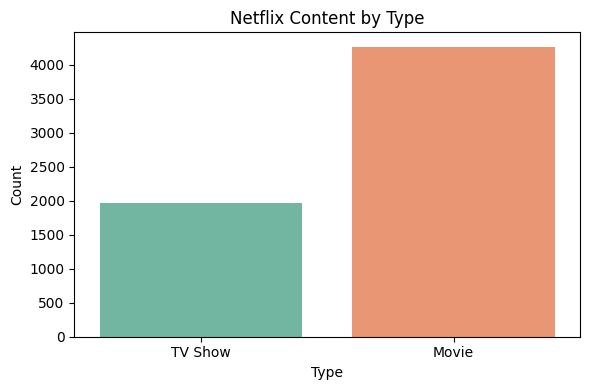

In [14]:
type_df = df_cleaned.groupBy("type").count()
pandas_type_df = type_df.toPandas()

# Plot
plt.figure(figsize=(6,4))
sns.barplot(data=pandas_type_df, x='type', y='count', palette='Set2')
plt.title("Netflix Content by Type")
plt.xlabel("Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Step 4: Visualization — Content released over the years

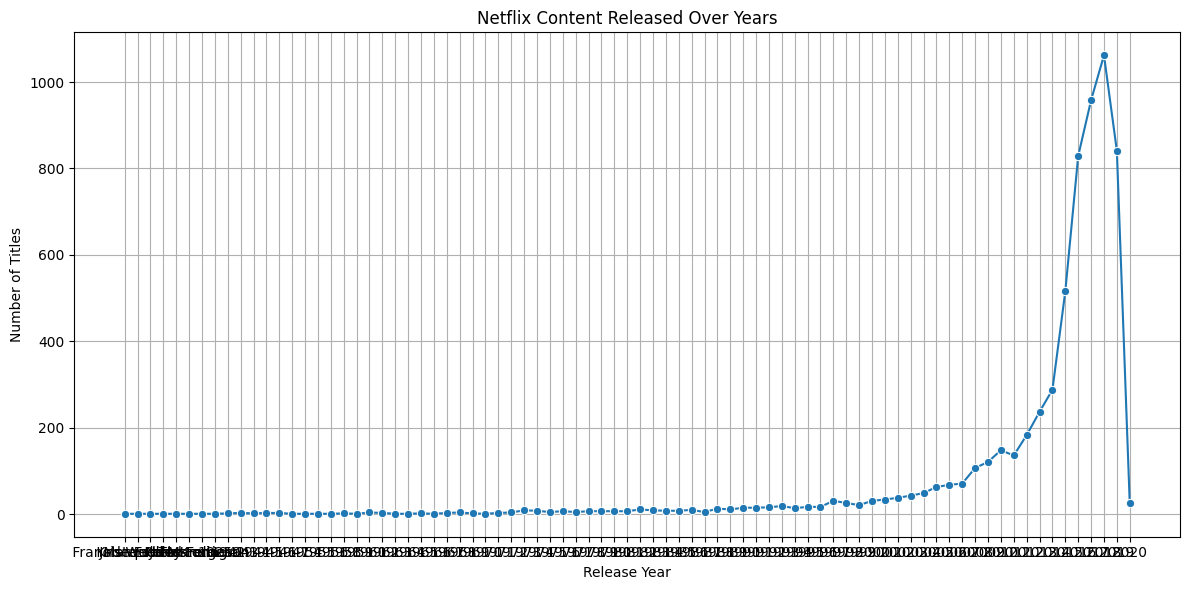

In [15]:
year_df = df_cleaned.groupBy("release_year").count().orderBy("release_year")
pandas_year_df = year_df.toPandas()

plt.figure(figsize=(12,6))
sns.lineplot(data=pandas_year_df, x='release_year', y='count', marker="o")
plt.title("Netflix Content Released Over Years")
plt.xlabel("Release Year")
plt.ylabel("Number of Titles")
plt.grid(True)
plt.tight_layout()
plt.show()

Step 5: Visualization — Top 10 genres (from 'listed_in')
Since listed_in can contain multiple genres, we split and flatten it.


<ipython-input-16-35b0154df4d5>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pandas_genre_df, x='count', y='genre', palette="coolwarm")


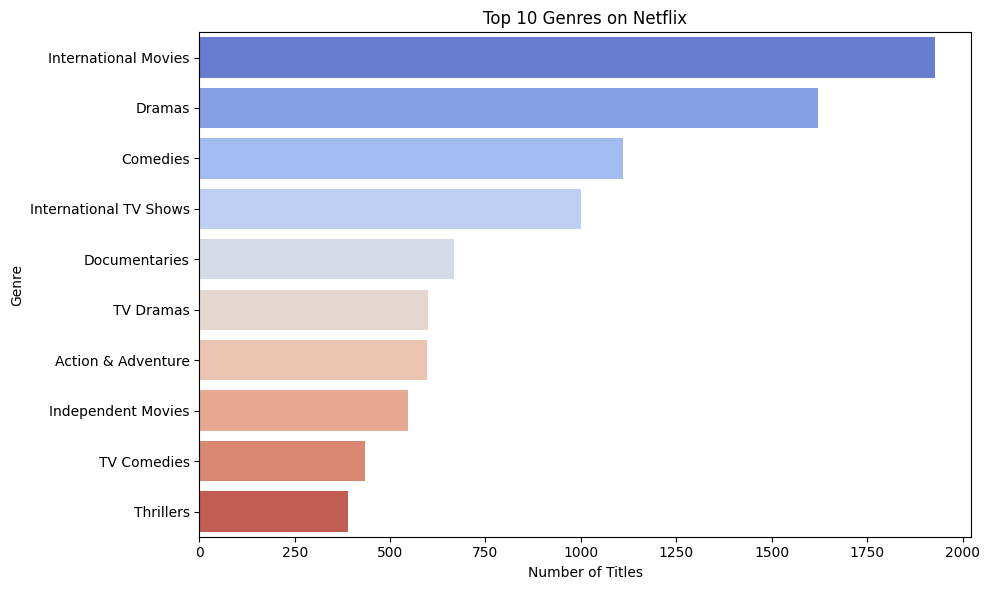

In [16]:
from pyspark.sql.functions import explode, split, trim

# Split genres and explode
genres_df = df_cleaned.withColumn("genre", explode(split("listed_in", ",")))
genres_df = genres_df.withColumn("genre", trim(col("genre")))

# Count and show top genres
top_genres = genres_df.groupBy("genre").count().orderBy("count", ascending=False).limit(10)
pandas_genre_df = top_genres.toPandas()

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=pandas_genre_df, x='count', y='genre', palette="coolwarm")
plt.title("Top 10 Genres on Netflix")
plt.xlabel("Number of Titles")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()